## Explainable AI - SHAP

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import lime 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('BankChurners.csv')

# preprocessing 
data.columns = [i.lower() for i in data.columns]
target_col = 'attrition_flag'
# changing the target names 
data[target_col] = data[target_col].map({'Existing Customer':0,'Attrited Customer':1})
x = data.drop(target_col,axis =1)
y = data[target_col]
x_train,x_test,y_train,y_test = train_test_split(
    x,y ,random_state=1, shuffle=True, stratify=y, test_size=0.4,
)

cat_cols = ['gender','education_level','marital_status','income_category','card_category']
x_train_encoded = pd.get_dummies(data = x_train,columns = cat_cols, drop_first = True)
training_cols =x_train_encoded.columns
x_test_encoded = pd.get_dummies(data = x_test,columns = cat_cols)[training_cols]

In [3]:
model = GradientBoostingClassifier()
model.fit(x_train_encoded,y_train)
y_pred_train = model.predict(x_train_encoded)
y_pred = model.predict(x_test_encoded)
classification_report =classification_report(y_pred,y_test)

print('Training score = ' ,model.score(x_train_encoded,y_train))
print('Testing score = ', model.score(x_test_encoded,y_test))
print(classification_report)

Training score =  0.9758064516129032
Testing score =  0.9674154529745742
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3442
           1       0.87      0.93      0.90       609

    accuracy                           0.97      4051
   macro avg       0.93      0.95      0.94      4051
weighted avg       0.97      0.97      0.97      4051



## SHAP - Shapley Additive Explanations 
### The interpretation of the Shapley value for feature value j is: The value of the j-th feature contributed $\large\phi_j$to the prediction of this particular instance compared to the average prediction for the dataset.
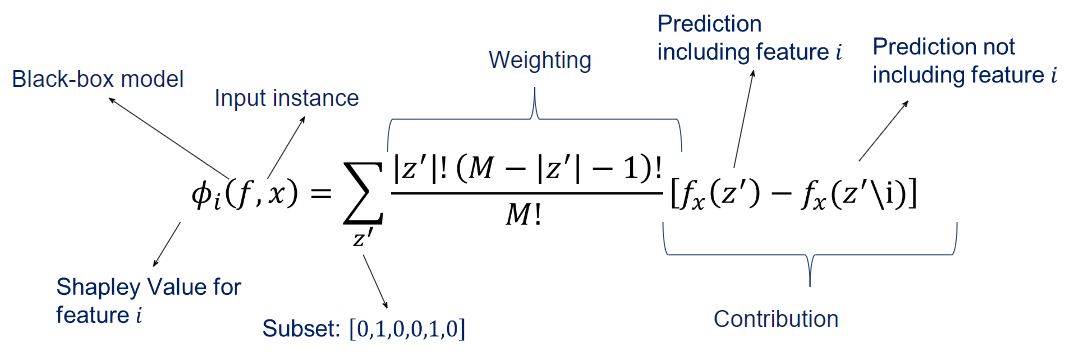

How to fairly distribute a payout among the player? 

Axioms: 

- Symmetry: If two players worked equally then they should receive equal payout.
- Dummy: Irrelevant players should get zero payout.
- Additivity: If a game has two sessions, then total payout for a player is the sum of contributions in the separate sessions.
- Efficiency: All players’ contributions must sum up to the total payout.

---

What is the contribution of the a feature in the prediction (for a particular instance).

There is an average value for the prediction. 

How much each feature contributes in the difference between average prediction and current prediction. 

We can have all the subsets and can find each marginal contribution for a particular feature.

If we have three features $x,y$ and $z$; we need to find the contribution of x in the prediction.

$f(x,y,z)-f(y,z)$ - marginal contribution of $x$  to $(x,y,z)$

$f(x)-f()$

$f(x,y)-f(y)$ 

$f(x,z)-f(z)$

Since it takes a lot of time if we have many number of features, we have a method to estimate shapley value. 

- we select a number of iterations - m , input instance - x , data matrix.
- Select a random instance - z
- Get a random permutation o
- arrange both the random instance and input instance as per the permutation.
- Create two vectors as follow
    - with feature j : $x_1, x_2, ...., x_{j-1}, x_j, z_{j+1}, ..., z_p.$
    - without the feature j: $x_1,x_2, ...,x_{j-1},z_j, ....,z_p$
- find the contribution by $f(x_{j+})- f(x_{j-})$
- Complete the iteration and find the average contribution
- Repeat for all the features.

-----------------------------------
Shap combines lime and shapley values to provide explanations for a model prediction.

In Shap we fit a linear model with Shap Kernel and the coefficients of that linear model will be shapley values. 

$g(x)= \phi_o + \sum\phi_j$; here $\phi_o$ represents the expected value of the prediction(using training data) 

We need to get the training data and targets for fitting the explanatory model $g.$

First step is create multiple coalitions. ($(1,0,1,0),(0,1,0,0) ...)$ 

Coalition of $(1,0,1,0)$ represents we have a coalition of first and third features. 

Then we use a function $h(x)$ for converting these coalitions to valid data instance. These instances will become the training instance for the explanatory model $g$.

Now we can have the predictions of these coalitions from our original model $f$. These predictions will become the targets of the upcoming explanatory model $g.$

We give weights each coalitions in such a way that small coalitions and large coalitions will get largest weights. - we get more information about a feature when we study it in isolation. 

$\pi_x(z')= \frac{M-1}{\binom{M}{|z'|}|z'|(M-|z'|)}$, $M$  is the number of features and $z'$ represents the number of ones in the coalition vector. 

we take the loss function as follows;  

$L(f,g,\pi_x) = \sum{(f(x)-g(x))^2}\pi_x$

Fit weighted linear model. 

Return the Shapley values $\phi_k$ , the  coefficients from the linear model.

* Research Paper : https://arxiv.org/abs/1705.07874 
* Tree SHAP Paper: https://arxiv.org/abs/1802.03888?context=cs
* Ml Interpreation : https://christophm.github.io/interpretable-ml-book/shap.html
* Finding the **marginal contribution of features in a prediction**. 
* The marginal contribution would mean how much each feature forces the prediction to move away from that baseline.
* The way Sharpley values **calculate the marginal contribution is by computing the predicted value with and without the feature value**  currently being considered and take the difference to get the marginal contribution. Finally, the Sharpley value is calculated by averaging the marginal contribution of the feature value **across all such possible feature subsets** (called coalitions) inside the feature set where the feature participates.

* However, you may start wondering how to **run a model “with and without a feature**” since most of the models can’t handle missing data. It basically replaces the feature values of features that are not in a coalition with random values from the dataset to get a prediction from the machine learning model. Another alternative is to use the expected value for such a feature.
* The **interpretation of the Shapley value** X is: The value of the feature A contributed X to the prediction of this particular instance compared to the average prediction for the dataset. More clearly, it is the contribution of a feature value to the difference between the actual prediction and the mean prediction.
 * Global bar plot (feature importance) 
 * Force Plot (individual prediction) 
 * Waterfall Plot ( individual prediction) 
 * Decision Plot ( individual predictions - cumulative effect) 
 * Dependence Plot ( feature interactions) 
 

In [4]:
import shap 
shap.initjs()

In [5]:
def logits_to_probabilities(logits):
    exp_logits = np.exp(logits)
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

import math
def log_odds_to_probability(log_odds):
    odds = math.exp(log_odds)
    probability = odds / (1 + odds)
    return probability

In [7]:
explainer = shap.TreeExplainer(
        model = model
        )
shap_values = explainer.shap_values(x_test_encoded)

instance_to_explain = 60
shap.force_plot(
    explainer.expected_value[0], # expected prediction 
    shap_values = shap_values[instance_to_explain], # shapley value for the instance of interest 
    features = x_test_encoded.iloc[instance_to_explain],  # feature values of the instance 
    feature_names= list(x_test_encoded.columns), # feature names of the model 
    # link = 'logit',# outputs is in probabilites otherwise it is in log odds units 
    contribution_threshold=0.04  # displaying only importance contributions 
)

If we pay attention, you will see at the very middle the legend “**Base value**”. This refers to the definition of Shapley values. We said that they are the contribution of a feature value to the difference between the actual prediction and the mean prediction. This number is the base prediction

`explainer.expected_value[0]` gives the expected probability of something being classifier as class 0. 

The arrows below the line indicate all the feature values that are moving the actual prediction from the base value. Feature values in red moves the prediction to bigger values from the baseline and blue arrow to smaller.

In [8]:
def shapely_explanation(data,model,inst):
    explainer = shap.TreeExplainer(
        model = model
        )
    shap_values = explainer.shap_values(data)
    
    temp = pd.DataFrame({'feature':data.columns,'shapley_values':shap_values[inst]})
    test_predictions = model.predict_proba(data)[:,1]
    base_value = explainer.expected_value[0] # expected prediction 
    shapely_values_sum = shap_values[inst].sum() # sum of all shapley values of the predictors 
    computed_prediction_logodds = base_value+shapely_values_sum  # base+shapely sum -> in log odds unit 
    probability_value = log_odds_to_probability(computed_prediction_logodds) # converting to probability 
    actual_model_prediction =test_predictions[inst]   #checking with actual model prediction for the instance 
    
    print('base value : ',base_value)
    print('shapely value sum : ',shapely_values_sum)
    print('computed prediction logodds : ',computed_prediction_logodds)
    print('probability value computed : ',probability_value)
    print('actual model prediction : ',actual_model_prediction)
    return temp

In [9]:
shapely_explanation(x_test_encoded,model,88)

base value :  -3.1269328765079374
shapely value sum :  -1.7115003353662521
computed prediction logodds :  -4.8384332118741895
probability value computed :  0.007857227500774543
actual model prediction :  0.007857227500774536


,feature,shapley_values
0,customer_age,0.020633
1,dependent_count,-0.000302
2,months_on_book,0.018778
3,total_relationship_count,0.007006
4,months_inactive_12_mon,-0.028532
5,contacts_count_12_mon,-0.087066
6,credit_limit,0.181516
7,total_revolving_bal,-0.166271
8,avg_open_to_buy,-0.005483
9,total_amt_chng_q4_q1,-0.035287


In [ ]:
# basic_explainer = shap.Explainer(model.predict, x_train_encoded)
# shap_values = basic_explainer(x_test_encoded.head(100))

In [ ]:
# shap.plots.bar(shap_values)
# Above graph is telling us the importance of each of the features at classifying. 

### Waterfall Plots 
Following is the **Waterfall Plot** for the getting the shapley value of an instance 
**Notes**: Units on the x-axis are log-odds units, so negative values imply probabilies of less than 0.5

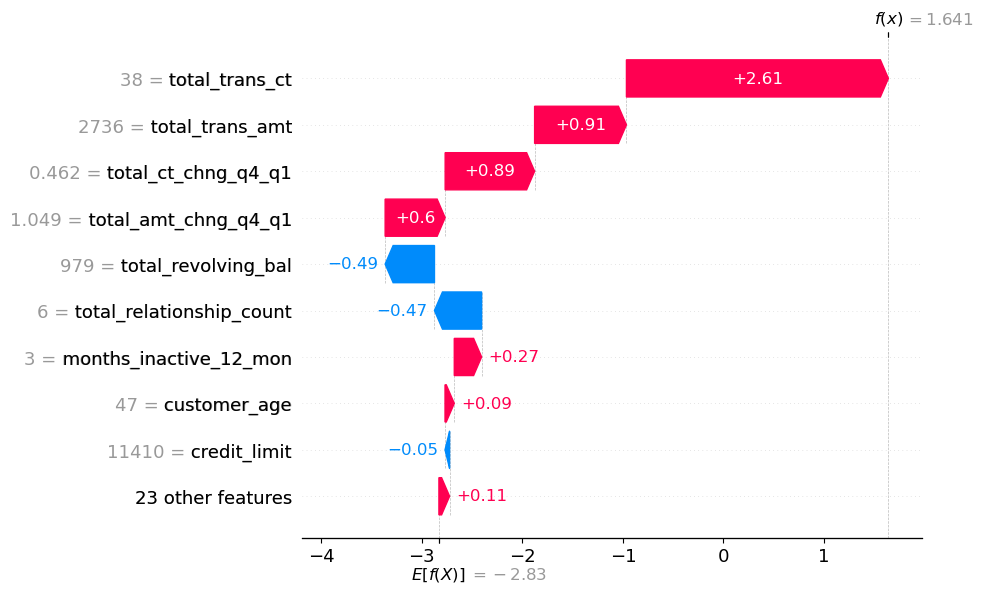

In [10]:
explainer = shap.Explainer(model, x_test_encoded)
shap_values = explainer(x_test_encoded)
shap.plots.waterfall(shap_values[60])

### Decision Plots 
Like a force plot, a decision plot shows the important features involved in a model's output. However a decision plot can be more helpful than a force plot when there are a large number of significant features involved. 
 * Show a large number of feature effects cleary 
 * Visualize multioutput predictions : https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html 
 * display cumulative effect of interactions 
 * Prediction path

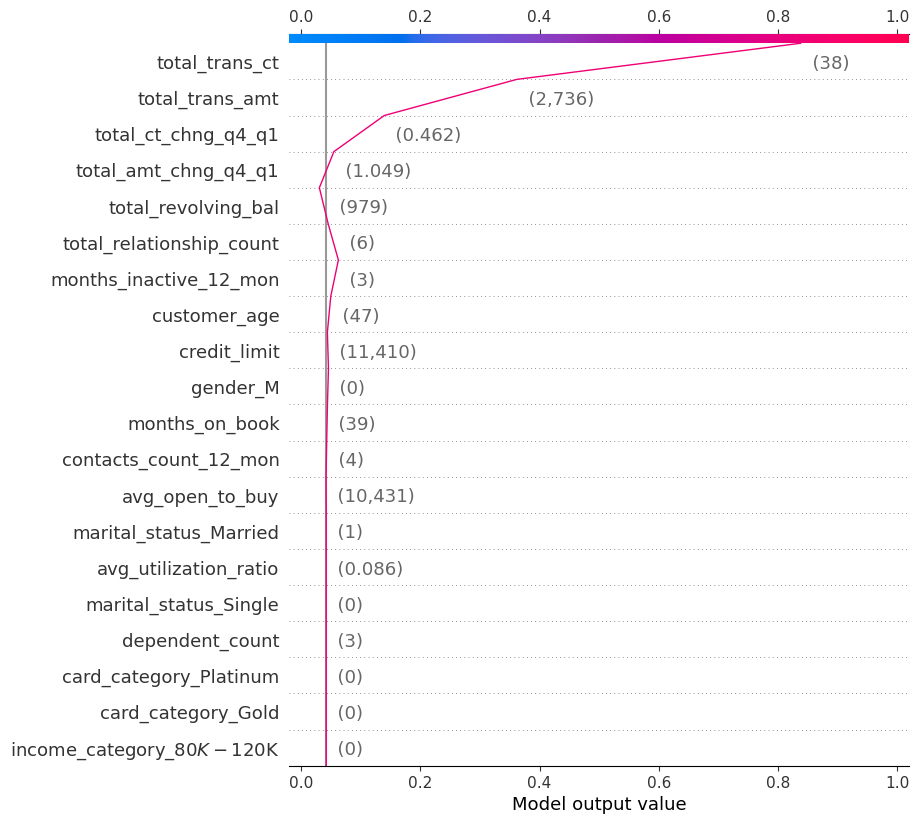

In [11]:
# kernelSHAP,TreeSHAP,DeepSHAP 
explainer = shap.TreeExplainer(
    model = model,
    link = shap.links.identity, 
    algorithm = 'auto', 
    # output_names ; names of the model outputs(classes)  
)
shap_values = explainer.shap_values(x_test_encoded)
instance_to_explain = 60
shap.decision_plot(
    explainer.expected_value[0], # expected prediction 
    shap_values = shap_values[instance_to_explain], # shapley value for the instance of interest 
    features = x_test_encoded.iloc[instance_to_explain],
    link='logit',  # output in terms of probability 
    )

In [12]:
shap_values[0]

array([ 5.51346492e-02, -1.51783616e-04, -1.95544175e-01, -1.03657542e-01,
        9.64036406e-02,  7.42105347e-02, -4.47233858e-02,  6.16374462e-01,
       -2.95430421e-03, -5.55393870e-02, -6.56067769e-01, -1.17726971e+00,
       -1.66735935e-01, -2.10145032e-04, -1.98679171e-02,  0.00000000e+00,
        5.19320539e-06,  1.36010334e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.80895034e-03, -4.40396593e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.62515891e-04,  0.00000000e+00,
        0.00000000e+00,  1.15884946e-04, -6.33077592e-04,  0.00000000e+00])

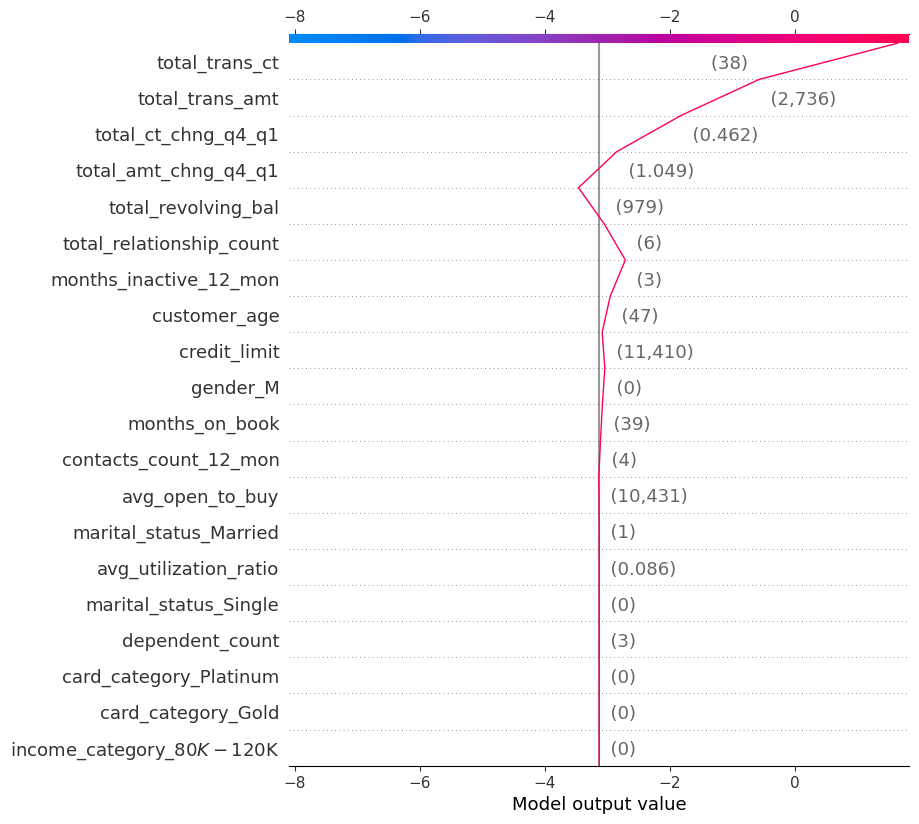

In [13]:
shap.decision_plot(
    explainer.expected_value[0], # expected prediction 
    shap_values = shap_values[instance_to_explain], # shapley value for the instance of interest 
    features = x_test_encoded.iloc[instance_to_explain]
)

### Simple dependence plot 
 * Scatter plot that shows the effect of a single feature has on the predictions made by the model. 
 * Each dot is a single prediction from the dataset. 
 * x axis is the value of feture 
 * y axis the shap value of that feature 
 * color corresponds to the second feature. 

For the example below 40-year-olds with a high level of transactional counts are getting higher shapley value than 40-year olds with a low level of transactional count. This suggests an interaction effect between customer age and total transactional count. 

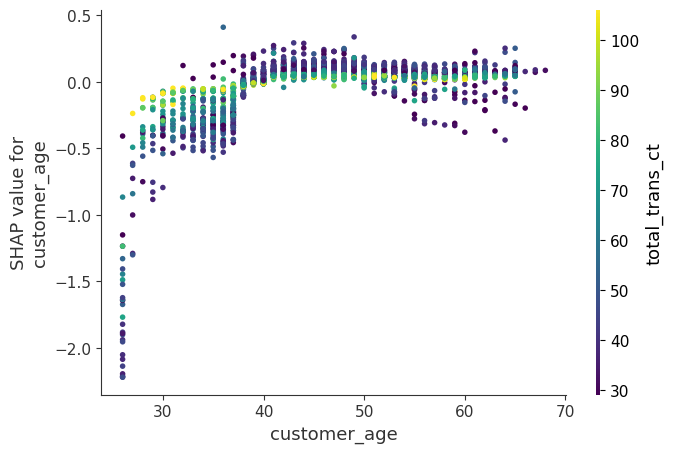

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_encoded)
shap.dependence_plot(
    'customer_age',
    shap_values,
    x_test_encoded,
    # interaction_index = 'gender_M',
    cmap = plt.get_cmap('viridis')
)

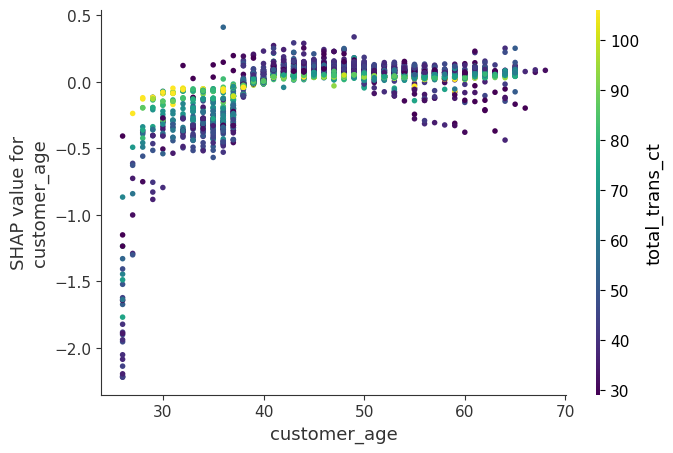

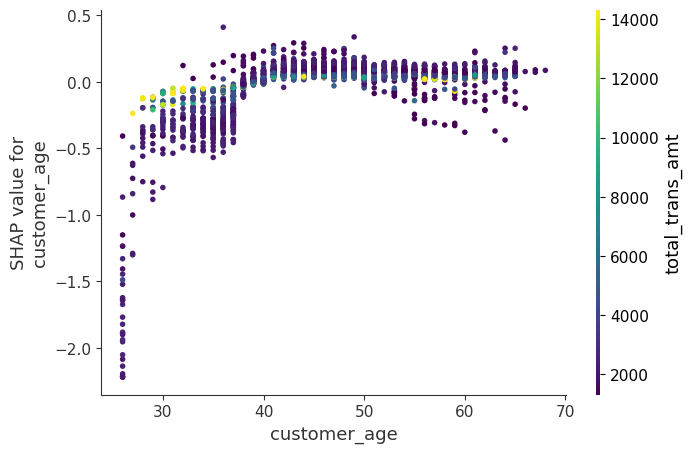

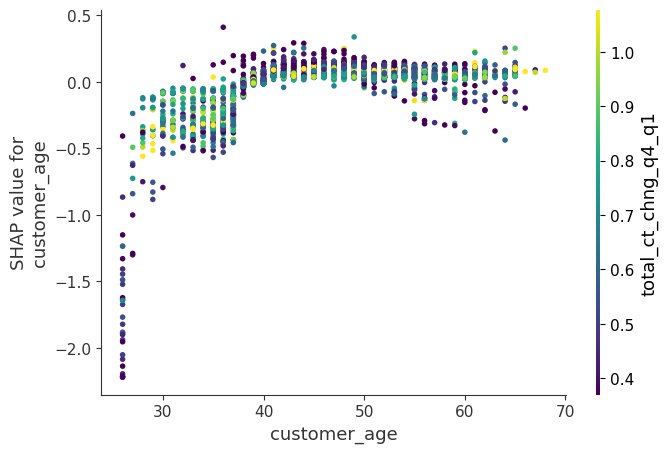

In [15]:
inds = shap.approximate_interactions(
    "customer_age", shap_values, x_test_encoded
)
# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot(
        "customer_age", shap_values, x_test_encoded, 
        interaction_index=inds[i],
        cmap = plt.get_cmap('viridis')
    )

We can also use rank(i) to specify the ith most important feature to the model. 


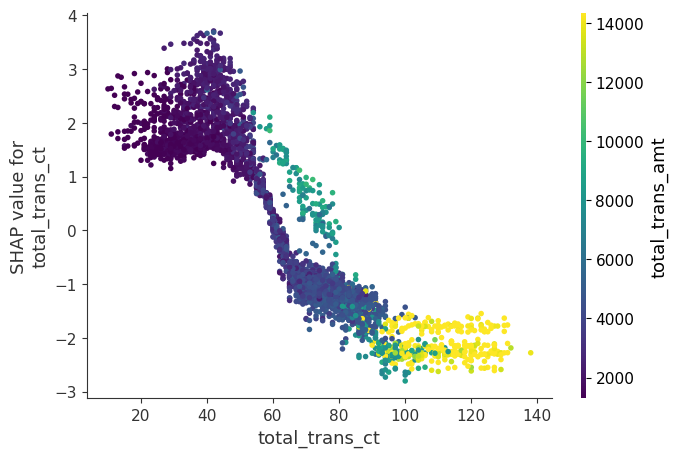

In [16]:
shap.dependence_plot(
    'rank(0)', shap_values, 
    x_test_encoded,cmap = plt.get_cmap('viridis'))